In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU')))

2.7.0
1


In [2]:
#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()
#x_train = x_train.reshape(-1, 28, 28, 1)
#x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

170508288/170498071 [==============================] - 6s 0us/step


In [9]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [10]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn1"),  
        keras.layers.Conv2D(32, (3, 3),name="conv2", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn2"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(64, (3, 3),name="conv3", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn3"),
        keras.layers.Conv2D(64, (3, 3),name="conv4", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn4"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(128, (3, 3),name="conv5", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn5"),
        keras.layers.Conv2D(128, (3, 3),name="conv6", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn6"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp3"),
        keras.layers.Dropout(0.2),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu', kernel_initializer='he_uniform'),
        keras.layers.BatchNormalization(name="bn7"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, name="dense3", activation='softmax')
    ],
    name="modelo-0.0",
)

for layer in model.trainable_variables:
    print(layer.name)
    if 'bias' in layer.name:
        new_bias = tf.cast(tf.where(tf.abs(layer) >= 0, 0.1, 0.1), tf.float32)
        layer.assign(new_bias)

model.summary()

conv1/kernel:0
conv1/bias:0
bn1/gamma:0
bn1/beta:0
conv2/kernel:0
conv2/bias:0
bn2/gamma:0
bn2/beta:0
conv3/kernel:0
conv3/bias:0
bn3/gamma:0
bn3/beta:0
conv4/kernel:0
conv4/bias:0
bn4/gamma:0
bn4/beta:0
conv5/kernel:0
conv5/bias:0
bn5/gamma:0
bn5/beta:0
conv6/kernel:0
conv6/bias:0
bn6/gamma:0
bn6/beta:0
dense1/kernel:0
dense1/bias:0
dense2/kernel:0
dense2/bias:0
bn7/gamma:0
bn7/beta:0
dense3/kernel:0
dense3/bias:0
Model: "modelo-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (64, 32, 32, 32)          896       
                                                                 
 bn1 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 conv2 (Conv2D)              (64, 32, 32, 32)          9248      
                                                                 
 bn2 (BatchNormalization)    (64,

In [11]:
epochs = 40
alpha = 0.5
n_bits = 32
learning_rate = 0.075
np.set_printoptions(threshold=np.inf)

model_sparsity = np.array([])
model_sparsity_layers = np.array([])
model_train_loss = np.array([])
model_train_acc = np.array([])
model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

for epoch in range(epochs):
    # Iterate over the batches of the dataset.
    acc_epoch_mean = np.array([])
    loss_epoch_mean = np.array([])

    acct_epoch_mean = np.array([])
    losst_epoch_mean = np.array([])
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
      #sparsity_batch = np.array([])
      #Verify if the model needs to be pruned
      n_zeros = 0
      size = 0

      #pruning
      if alpha > 0:
        bk = []
        for layer_weights in model.trainable_variables:
          if 'bn' in layer_weights.name:
              bk.append(-1)
          else:
              #flatten weights
              f_weights = tf.reshape(layer_weights,[-1])
              #get standard deviation of each layer
              lim = alpha*tf.math.reduce_std(f_weights)
              bk.append(lim)
              #create a mask
              mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)
              #assign pruned weights to the layer
              layer_weights.assign(tf.math.multiply(layer_weights,mask))
              #check sparsity
              flat_array = np.array((tf.reshape(mask,[-1])))
              n_zeros += np.count_nonzero(np.array(flat_array) == 0)
              #n_zeros = np.count_nonzero(m)
              size += flat_array.shape[0]
              #print(size)
              #print(n_zeros)
              sparsity = n_zeros*100/size
      else:
        bk = [0] * len(model.trainable_weights)

      #Cópia do modelo
      if n_bits > 0 and alpha > 0:
          model_copy = keras.models.clone_model(model)
          model_copy.set_weights(model.get_weights())
      '''
      #Quantização
      if n_bits > 0 and alpha > 0:
          for i, layer_weights in enumerate(model.trainable_variables):
              #print(layer_weights.name)
              if 'bn' in layer_weights.name:
                  pass
              else:
                  qk_line = (tf.reduce_max(tf.math.abs(layer_weights)) - bk[i]) / (2 ** (n_bits - 1) - 1)
                  ck = tf.math.round(layer_weights / qk_line) * qk_line
                  layer_weights.assign(ck)
      '''
      
      with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss = loss_fn(y_batch_train, pred)
        
      grads = tape.gradient(loss, model.trainable_weights)

      


      if n_bits > 0 and alpha > 0:
          for i, (layer_weights, copied_weights) in enumerate(zip(model.trainable_variables, model_copy.trainable_variables)):
              grads[i] = grads[i] * learning_rate
              # WEIGHT UPDATE
              layer_weights.assign(tf.math.subtract(copied_weights, grads[i]))
      else:
          for i, layer_weights in enumerate(model.trainable_variables):
              grads[i] = grads[i] * learning_rate
              #WEIGHT UPDATE
              layer_weights.assign(tf.math.subtract(layer_weights, grads[i]))
          #optimizer.apply_gradients(zip(grads, model.trainable_weights))
      
      #optimizer.apply_gradients(zip(grads, model.trainable_weights))


      #Quantização
      if n_bits > 0:
          for i, layer_weights in enumerate(model.trainable_variables):
              #print(layer_weights.name)
              if 'bn' in layer_weights.name:
                  pass
              else:
                  qk_line = (tf.reduce_max(tf.math.abs(layer_weights)) - bk[i]) / (2 ** (n_bits - 1) - 1)
                  ck = tf.math.round(layer_weights / qk_line) * qk_line
                  layer_weights.assign(ck)


      predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
      acc = train_accuracy(y_batch_train, predictions)

      acc_epoch_mean = np.append(acc_epoch_mean, acc)
      loss_epoch_mean = np.append(loss_epoch_mean, loss)

    #Pruning
    if alpha > 0:
        bk = []
        for layer_weights in model.trainable_variables:
            if 'bn' in layer_weights.name:
                bk.append(-1)
            else:
                #flatten weights
                f_weights = tf.reshape(layer_weights,[-1])
                #get standard deviation of each layer
                lim = alpha*tf.math.reduce_std(f_weights)
                bk.append(lim)
                #create a mask
                mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)
                #assign pruned weights to the layer
                layer_weights.assign(tf.math.multiply(layer_weights,mask))
                #check sparsity
                flat_array = np.array((tf.reshape(mask,[-1])))
                n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                #n_zeros = np.count_nonzero(m)
                size += flat_array.shape[0]
                #print(size)
                #print(n_zeros)
                sparsity = n_zeros*100/size
    else:
        bk = [0] * len(model.trainable_weights)

    #Quantização
    '''
    if n_bits > 0 and alpha > 0:
        for i, layer_weights in enumerate(model.trainable_variables):
            if 'bn' in layer_weights.name:
                pass
            else:
                qk_line = (tf.reduce_max(tf.math.abs(layer_weights)) - bk[i]) / (2 ** (n_bits - 1) - 1)
                ck = tf.math.round(layer_weights / qk_line) * qk_line
                layer_weights.assign(ck)
    '''
    bk.clear()
    
    #Test
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
      test_pred = model(x_batch_test, training=False)
      test_loss = loss_fn(y_batch_test,test_pred)
      test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
      test_acc = test_accuracy(y_batch_test, test_prediction)

      acct_epoch_mean = np.append(acc_epoch_mean, test_acc)
      losst_epoch_mean = np.append(loss_epoch_mean, test_loss)

    #save mean results on lists
    model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean)*100)
    model_test_loss = np.append(model_test_loss,np.mean(losst_epoch_mean)*100)

    model_sparsity = np.append(model_sparsity,sparsity)

    model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean))
    model_train_loss = np.append(model_train_loss,np.mean(loss_epoch_mean))
    
    print("Epoch {}/{} \t Loss = {:.3f} \t Train Acc = {:.3f}% \t Sparsity = {:.3f}% \t Test Acc = {:.3f}%".format(epoch+1,epochs,float(loss),float(acc*100),sparsity,float(test_acc*100)))

Epoch 1/40 	 Loss = 1.000 	 Train Acc = 48.620% 	 Sparsity = 38.331% 	 Test Acc = 56.810%
Epoch 2/40 	 Loss = 1.119 	 Train Acc = 55.918% 	 Sparsity = 40.707% 	 Test Acc = 61.740%
Epoch 3/40 	 Loss = 0.746 	 Train Acc = 60.249% 	 Sparsity = 42.727% 	 Test Acc = 63.397%
Epoch 4/40 	 Loss = 0.486 	 Train Acc = 63.280% 	 Sparsity = 44.436% 	 Test Acc = 65.750%
Epoch 5/40 	 Loss = 1.455 	 Train Acc = 65.603% 	 Sparsity = 45.966% 	 Test Acc = 66.154%
Epoch 6/40 	 Loss = 1.011 	 Train Acc = 67.490% 	 Sparsity = 47.417% 	 Test Acc = 66.225%
Epoch 7/40 	 Loss = 0.124 	 Train Acc = 69.077% 	 Sparsity = 48.800% 	 Test Acc = 67.924%
Epoch 8/40 	 Loss = 0.672 	 Train Acc = 70.412% 	 Sparsity = 50.136% 	 Test Acc = 68.820%
Epoch 9/40 	 Loss = 0.213 	 Train Acc = 71.613% 	 Sparsity = 51.437% 	 Test Acc = 70.019%
Epoch 10/40 	 Loss = 0.481 	 Train Acc = 72.657% 	 Sparsity = 52.695% 	 Test Acc = 70.925%
Epoch 11/40 	 Loss = 0.108 	 Train Acc = 73.610% 	 Sparsity = 53.886% 	 Test Acc = 71.823%
Epoch 12

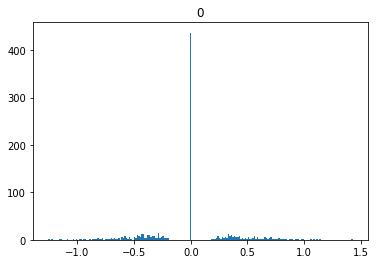

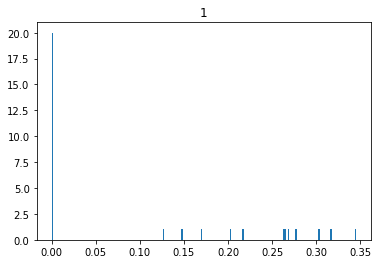

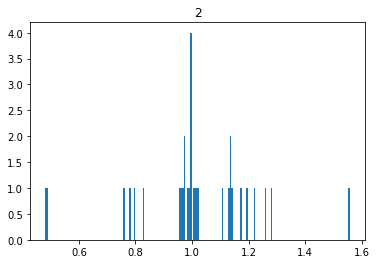

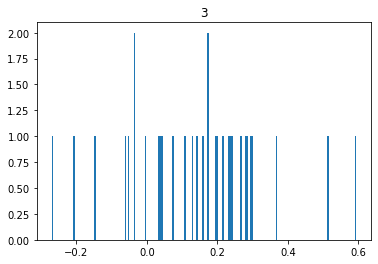

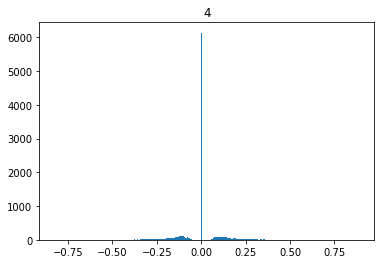

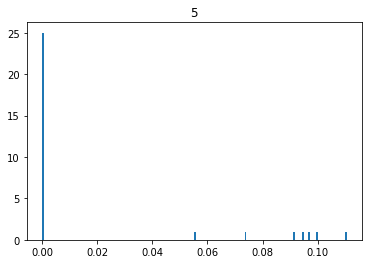

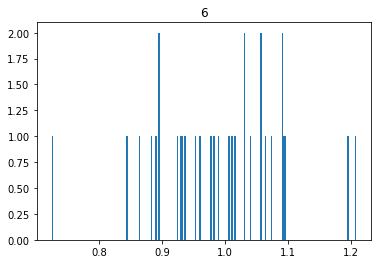

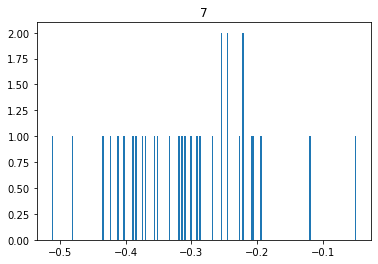

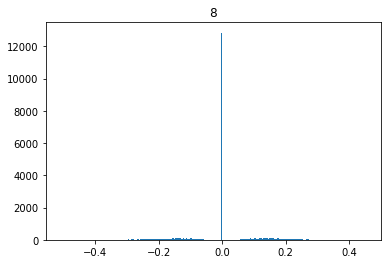

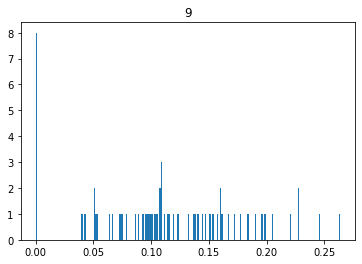

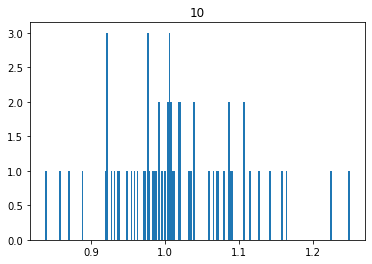

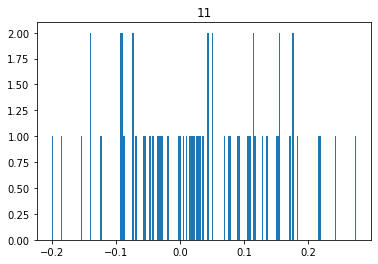

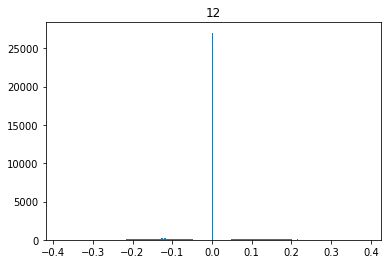

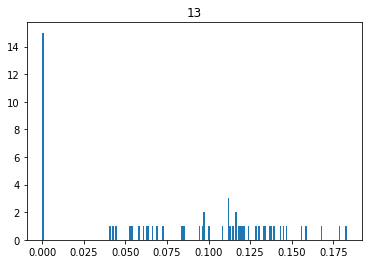

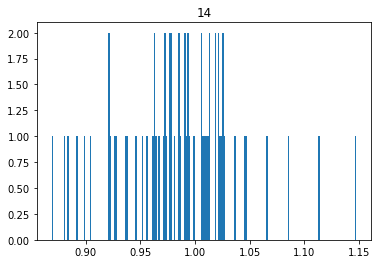

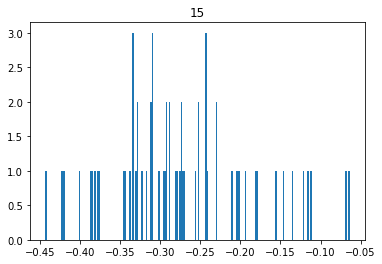

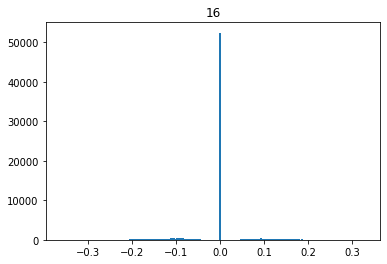

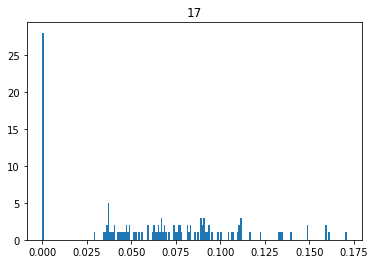

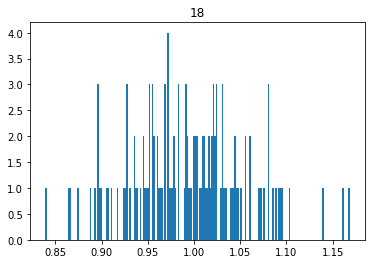

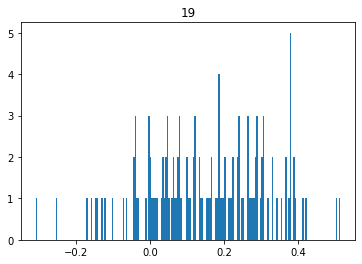

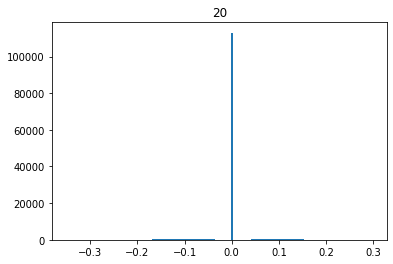

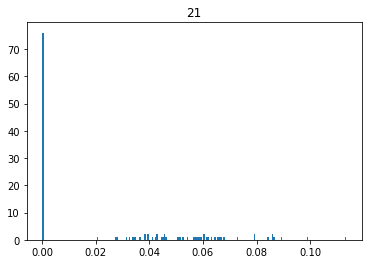

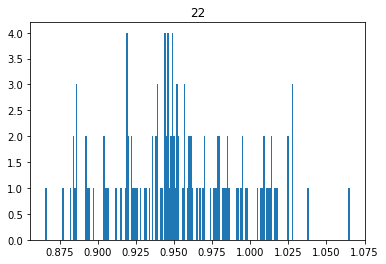

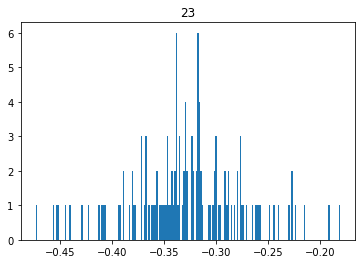

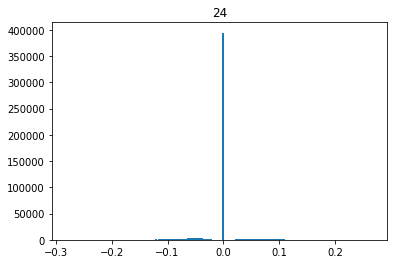

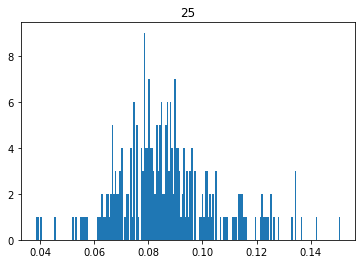

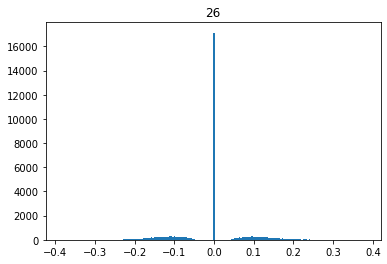

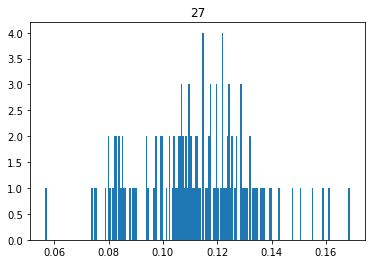

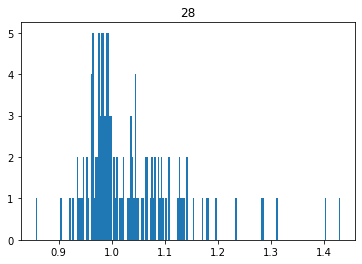

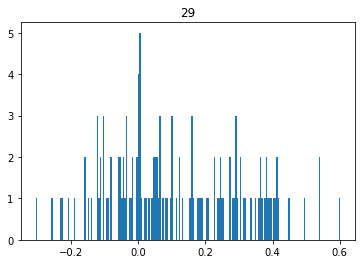

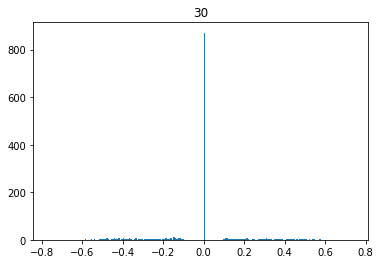

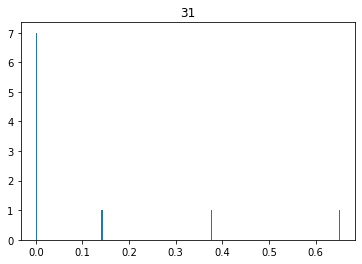

In [12]:
l = len(model.trainable_weights)
for i in range(l):
  a = tf.reshape(model.trainable_weights[i],[-1])
  b = a.numpy()
  #print(a)
  #plt.ylim(0,300)
  plt.title(str(i))
  plt.hist(b,200)
  plt.show()

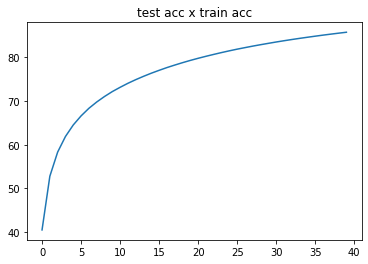

In [13]:
plt.title("test acc x train acc")
plt.plot(model_test_acc)
#plt.plot(model_train_acc)
plt.show()

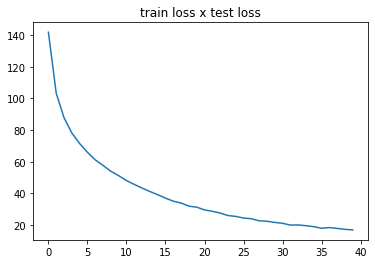

In [14]:
plt.title("train loss x test loss")
plt.plot(model_test_loss)
#plt.plot(model_train_loss)
plt.show()

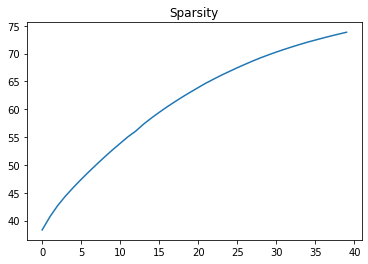

In [15]:
plt.title("Sparsity")
plt.plot(model_sparsity)
plt.show()

In [16]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    figure(figsize=(10, 7), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm[:,0])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]*100/1000) + "%",
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')


In [17]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 82.710%


Confusion matrix, without normalization


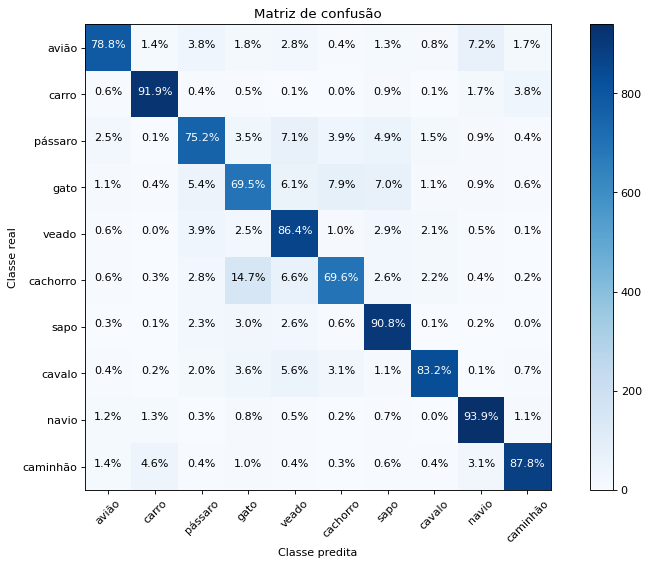

In [18]:
classes = ["avião","carro","pássaro","gato","veado","cachorro","sapo","cavalo","navio","caminhão"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Matriz de confusão')